Combined implementation of BB84 and RA-ODCN with .py files

# Structured

This is a structured file, an upgrade to the systematicically assembled file to perform the entire task. The functions used are stored in 2 '.py' files in the utils folder. Notebooks from the folder 'routines' act as a routine during the run time.

Here, we define the edge data for the graph(NSFNET, Six-Node), followed by creating the graph by invoking a function from another file. The parameters required are defined here, including the X range and k. Then the file 'QKRA' is invoked to perform RWTA.

Following this, the average is calculated from all the runs of QKRA, and the value is plotted.

1. Run BB84 at the start: It fills the KEY_RESERVOIR with num_CRs * key_len * avg_hop_count number of *key bits*. This reservoir will be accessible to every link to fetch keys from.
2. Generate the bidirectional Network Topology by providing the edges data. Create a list of k-shortest paths between each node.
3. Set the parameter values(num_CRs, aslc, k, num_iter, *X range*). Initialize the quantities to be studied(SRCR, TUR, NSP).
4. Initiate the QKRA protocol (to be ran  num_iter times)

### QKRA
1. Initialize the links. Allocate the resources.
    * For bidirectional graph, the number of links will double(2 unidirectional link between each available pair of nodes). Ordered Indices   matrix needed.
    * The quantum keys will be associated with each QSC time-slot of each link.
    * Each link will encode/decode the text for CR
2. Generate a set of X CRs. Initialize the attributes.
    * Create a priority queue. Apply FF for each successive shortest path until success/exhaustion.   
    * The text to be sent will be associated with the CR. Call cipher function. Update the quantities of interest.
4. A cipher function will simulate the encryption/decryption of the data for each link involved. Including the usage of TDC.
    * A link (node_1, node_2) with a qkey : Encrypt on node_1, use TDC to share the ciphertext, decrypt on node_2.
    * Q : time for this to be counted?


# 1. Preamble

In [1]:
import sys
from sys import getsizeof
import os

import time
from contextlib import contextmanager
import warnings

import numpy as np
import tqdm
from functools import reduce
from scipy.optimize import curve_fit

import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import pandas

from qiskit import *
from qiskit.qasm2 import dumps
from qiskit_aer import Aer

import math

## 1.1 Defining Paths

In [2]:
# Define the subdirectory name for storing ODCN figures
fig_subdirectory = "Figures"
if not os.path.exists(fig_subdirectory):    # Check if the subdirectory exists
    os.makedirs(fig_subdirectory)
    
# For writing ODCN data
data_subdirectory = "Data"
if not os.path.exists(data_subdirectory):
    os.makedirs(data_subdirectory)

# For writing BB84 Data
bb84_subdirectory = "BB84"
if not os.path.exists(bb84_subdirectory):
    os.makedirs(bb84_subdirectory)

# Setting the precision for floating points :
np.set_printoptions(precision=4)

# 2. Loading dependencies

In [3]:
%run ./Dependencies.ipynb
# from utils.RA import create_bi_topology, k_sp, CR, Links
# from utils.bb84 import *                                                       # Includes functions needed for Hamming
# from utils.helper import suppress_stdout   
# from utils.helper import suppress_std as quiet

# 3. Stock the quantum generated keys

## 3.1 Parameters

In [4]:
write_bb84 = False
eve_presence = 'Random'                    #'Random'
ch_noise = 1e-4                            # 0.000 - 0.300, 0.050 V/s QBER (eve detection)
eve_threshold = 20e-2                      # QBER_threshold = eve_threshold - ch_noise ( 0.25(+-0.01) - 0.02 (+-0.001) = 0.23 +- 0.011 )

num_iter = 1
num_keys = 100                          #
KEY_LENGTH = 1000                            # Should not be <
key_size = KEY_LENGTH

 Keys generated: [====================>] 100/100
 0.019913434982299805
Eve-detection was incorrect : 100/0 times (= inf ); for QBER Threshold : 0.09985000000000002
Eve Detection[Noise 0.0001]


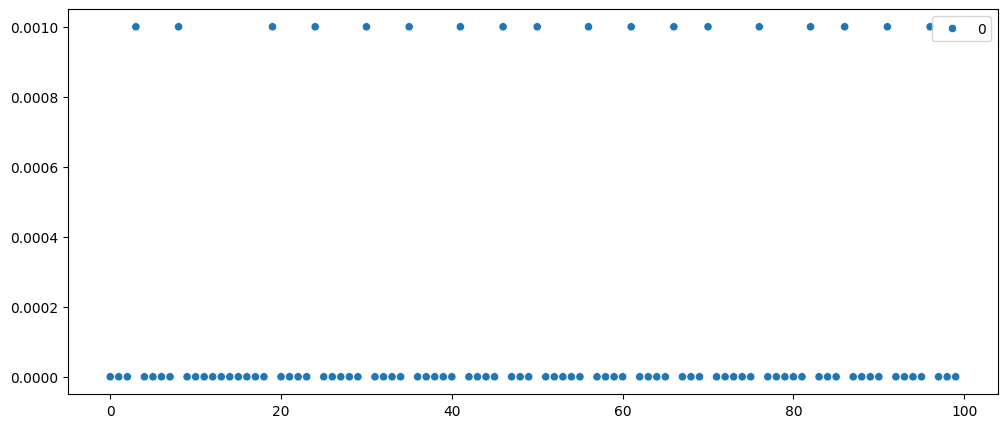


Size and Type :

num_iter           :   Sys size : 28    ,  np size : NA      <class 'int'> 
num_keys           :   Sys size : 28    ,  np size : NA      <class 'int'> 
key_size           :   Sys size : 28    ,  np size : NA      <class 'int'> 
write_bb84         :   Sys size : 24    ,  np size : NA      <class 'bool'> 
eve_presence       :   Sys size : 55    ,  np size : NA      <class 'str'> 
ch_noise           :   Sys size : 24    ,  np size : NA      <class 'float'> 
eve_threshold      :   Sys size : 24    ,  np size : NA      <class 'float'> 
Eve_detected       :   Sys size : 212   ,  np size : 100      <class 'numpy.ndarray'> 
KEY_RESERVOIR_len  :   Sys size : 312   ,  np size : 200      <class 'numpy.ndarray'> 
time_taken         :   Sys size : 512   ,  np size : 400      <class 'numpy.ndarray'> 
QBERs              :   Sys size : 512   ,  np size : 400      <class 'numpy.ndarray'> 
KEY_RESERVOIR      :   Sys size : 56    ,  np size : NA      <class 'list'> 


Data Examples :
 


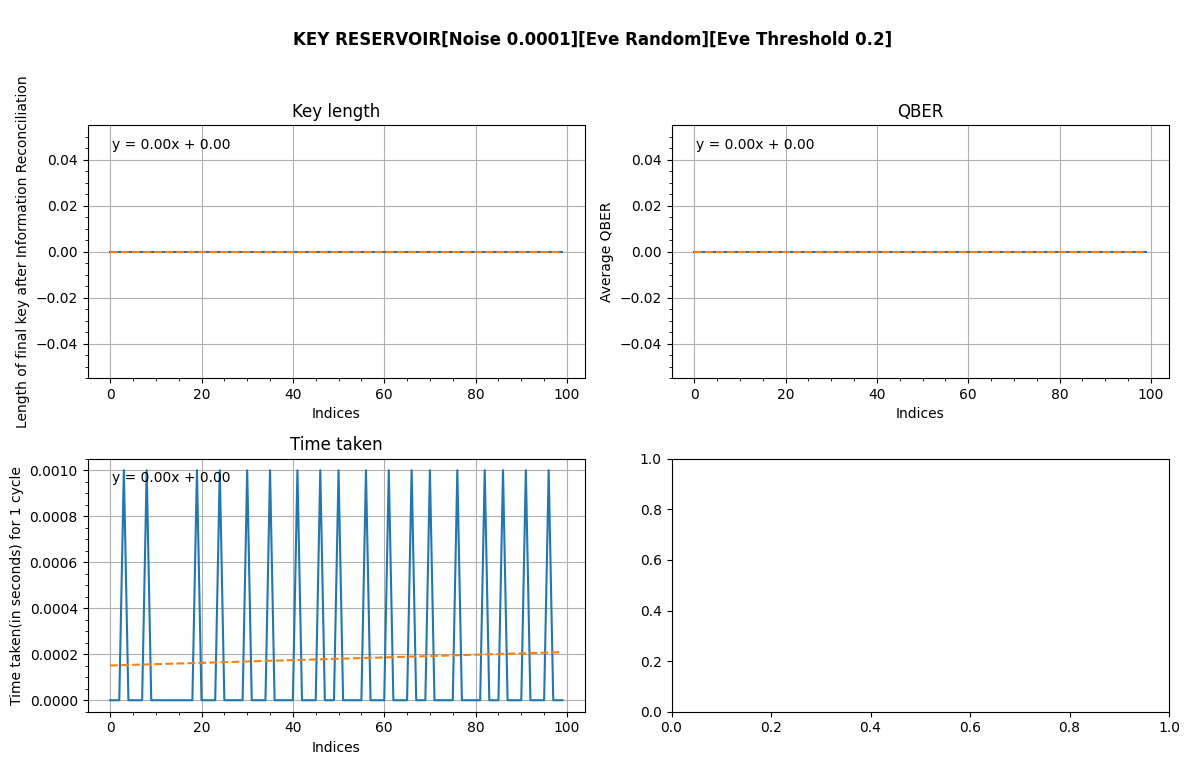


KEY RESERVOIR[Noise 0.0001][Eve Random][Eve Threshold 0.2] 
All_parameters[Noise 0.0001]


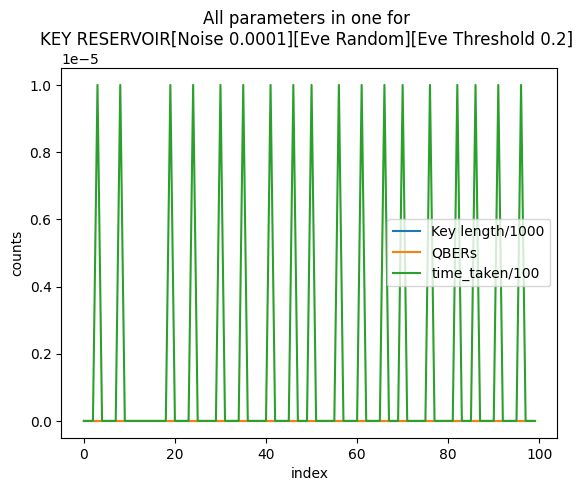

'\nwith suppress_stdout():\n    # Performs the entire protocol for 1 key till Key-Reconciliation QBER\n    # Prepares the input string, encodes, and transmits Alice bits(3*KEY_LENGTH)\n    # If Eve is present, intercepts : Measures and Resends after encoding to Bob\n    # Sifts, Reconciles/spots\n    %run ./routines/BB84/protocol_1key.ipynb    \n'

In [5]:
# Initializes arrays : time_taken, QBERs, KEY_RESERVOIR, KEY_RESERVOIR_len, Eve_detected 
# Perform test and checks and outputs the variable examples
# %run ./routines/BB84/initialization_bb84.ipynb
precision = eve_threshold/2 + ch_noise/2   
error_threshold = eve_threshold - ch_noise - precision

indices = np.arange(num_keys).astype('float32')
time_taken = np.zeros(num_keys, dtype = 'float32')    # avg time taken by a key of a certain length
QBERs = np.zeros(num_keys, dtype = 'float32')
KEY_RESERVOIR = []
KEY_RESERVOIR_len = np.zeros(num_keys, dtype = 'uint16')
Eve_detected = np.zeros(num_keys, dtype='uint8')

SKGR = 0
flag = 0

# Creates the required number of keys by looping over the file that creates 1 key
# Also tackles error-correction(if needed)
# Calculates the Secure Key Generation Rate(SKGR) and the averages of corresponding quantities
%run ./routines/BB84/start_iter_calc.ipynb
# The below part is inside the start_iter_calc file
"""
with suppress_stdout():
    # Performs the entire protocol for 1 key till Key-Reconciliation QBER
    # Prepares the input string, encodes, and transmits Alice bits(3*KEY_LENGTH)
    # If Eve is present, intercepts : Measures and Resends after encoding to Bob
    # Sifts, Reconciles/spots
    %run ./routines/BB84/protocol_1key.ipynb    
"""
# if flag == 1: 


In [6]:
print(KEY_RESERVOIR)

[]


In [ ]:
# Refactoring the key generation loop for clarity and efficiency

def run_key_generation(num_keys, key_length, eve_presence='Random', ch_noise=1e-4, eve_threshold=20e-2):
    """
    Run the BB84 quantum key generation protocol for a specified number of keys.
    
    Parameters:
        num_keys (int): The number of keys to generate.
        key_length (int): The length of each key.
        eve_presence (str): Mode of eavesdropper presence ('Random' or other).
        ch_noise (float): Channel noise affecting the QBER.
        eve_threshold (float): Threshold for eavesdropper detection.
        
    Returns:
        dict: A dictionary containing metrics like time taken, QBERs, and key reservoir.
    """
    # Initialize variables
    precision = eve_threshold / 2 + ch_noise / 2
    error_threshold = eve_threshold - ch_noise - precision
    
    indices = np.arange(num_keys).astype('float32')
    time_taken = np.zeros(num_keys, dtype='float32')    # avg time taken by a key of a certain length
    QBERs = np.zeros(num_keys, dtype='float32')
    KEY_RESERVOIR = []
    KEY_RESERVOIR_len = np.zeros(num_keys, dtype='uint16')
    Eve_detected = np.zeros(num_keys, dtype='uint8')
    
    for i in range(num_keys):
        # Simulate key generation and QBER calculation
        start_time = time.time()
        # Placeholder for key generation logic (to be implemented)
        QBERs[i] = ch_noise + np.random.rand() * precision  # Simulating QBER
        key = np.random.randint(2, size=key_length)         # Generating a random key
        KEY_RESERVOIR.append(key)
        KEY_RESERVOIR_len[i] = len(key)
        time_taken[i] = time.time() - start_time
        
        # Simulate Eve detection logic (placeholder)
        if QBERs[i] > error_threshold:
            Eve_detected[i] = 1
    
    # Compile results
    results = {
        'time_taken': time_taken,
        'QBERs': QBERs,
        'KEY_RESERVOIR': KEY_RESERVOIR,
        'KEY_RESERVOIR_len': KEY_RESERVOIR_len,
        'Eve_detected': Eve_detected
    }
    
    return results

# Testing the refactored function with sample inputs
sample_results = run_key_generation(num_keys=100, key_length=1000)
sample_results
